In [1]:
import numpy as np
import scanpy as sc
import anndata
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

#import cell2location
import scvi
import os

Global seed set to 0
/home/jovyan/my-conda-envs/myenv/lib/python3.9/site-packages/pytorch_lightning/utilities/warnings.py:53: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  new_rank_zero_deprecation(
/home/jovyan/my-conda-envs/myenv/lib/python3.9/site-packages/pytorch_lightning/utilities/warnings.py:58: LightningDeprecationWarning: The `pytorch_lightning.loggers.base.rank_zero_experiment` is deprecated in v1.7 and will be removed in v1.9. Please use `pytorch_lightning.loggers.logger.rank_zero_experiment` instead.
  return new_rank_zero_deprecation(*args, **kwargs)


In [2]:
os.chdir('/lustre/scratch126/cellgen/team297/bs16/current_projects/kidney_glomTI_response/code')
import useful_functions as uf

In [3]:
results_folder = '/lustre/scratch126/cellgen/team297/bs16/current_projects/kidney_glomTI_response/data/cell2location'
# create paths and names to results folders for reference regression and cell2location models
ref_run_name = f'{results_folder}/reference_signatures'
run_name = f'{results_folder}/cell2location_map'

In [4]:
def read_in_visium(sample_name, path):
        r""" This function reads the data for one 10X spatial experiment into the anndata object.
        :param sample_name: Name of the sample
        :param path: path to data
        """

        adata = sc.read_visium(path + str(sample_name),
                           count_file='filtered_feature_bc_matrix.h5', load_images=True
                              )
        adata.obs['sample'] = sample_name
        adata.var['Symbol'] = adata.var_names
        adata.var.rename(columns={'gene_ids': 'ID'}, inplace=True)
        adata.var_names_make_unique() 
        adata.obs["sample"] = [str(i) for i in adata.obs['sample']]
        adata.obs_names = adata.obs["sample"] \
                          + '_' + adata.obs_names
        adata.obs.index.name = 'spot_id'
        adata.obsm['spatial'] = adata.obsm['spatial'].astype(int)
        
        #calculate QC metrics
        from scipy.sparse import csr_matrix
        adata.X = adata.X.toarray()
        sc.pp.calculate_qc_metrics(adata, inplace=True)
        adata.X = csr_matrix(adata.X)
        adata.var['MT'] = [gene.startswith('MT-') for gene in adata.var['Symbol']]
        adata.obs['MT_frac'] = adata[:, adata.var['MT'].tolist()].X.sum(1).A.squeeze()/adata.obs['total_counts']

        
        return adata
def select_slide(adata, s, s_col='sample'):
        r""" This function selects the data for one slide from the spatial anndata object.

        :param adata: Anndata object with multiple spatial experiments
        :param s: name of selected experiment
        :param s_col: column in adata.obs listing experiment name for each location
        """

        slide = adata[adata.obs[s_col].isin([s]), :]
        s_keys = list(slide.uns['spatial'].keys())
        s_spatial = np.array(s_keys)[[s in k for k in s_keys]][0]

        slide.uns['spatial'] = {s_spatial: slide.uns['spatial'][s_spatial]}
    
        return slide

In [5]:
#read in the details we need about the kidneys to look at
seq_inventory = pd.read_csv("/nfs/team297/bs16/sample_donor_data/sequencing_inventory.csv")
seq_inventory = seq_inventory[seq_inventory.experiment.isin(["10X_visium_FFPE"])]
perfusion_kidneys = ['K281', 'K282', 'K283', 'K287', "K288", 'K289', "K290"]
seq_inventory = seq_inventory[~seq_inventory.donor.isin(perfusion_kidneys)]
seq_inventory = seq_inventory[~seq_inventory.poor_QC]
seq_inventory = seq_inventory[~seq_inventory.irods_dir.isna()]

In [6]:
#remove the pilot experiments - the data quality is slightly lower, and the chemistry is different; these can go with the perfusion data as control data.
v1_samples = ['K280_NBF1', 'K279_NBF1']
seq_inventory = seq_inventory[~seq_inventory.donor.isin(v1_samples)]

In [7]:
seq_inventory

donor     date     submission_channel         sequencing_sample_name  \
248     K292  14_6_23  kidney_ffpe_visium_29          AC19-KID-1-FFPE-1-S17   
249     K291  14_6_23  kidney_ffpe_visium_30         ACmc7-KID-1-FFPE-1-S13   
250     K285  14_6_23  kidney_ffpe_visium_31          ACmc1-KID-1-FFPE-1-S9   
251     K286  14_6_23  kidney_ffpe_visium_32         ACmc2-KID-1-FFPE-1-S11   
252     K294  14_6_23  kidney_ffpe_visium_33          AC20-KID-1-FFPE-3-S15   
253     K295  14_6_23  kidney_ffpe_visium_34          AC21-KID-1-FFPE-1-S11   
254     K296  14_6_23  kidney_ffpe_visium_35           AC22-KID-1-FFPE-1-S7   
255     K295  14_6_23  kidney_ffpe_visium_36          AC21-KID-1-FFPE-3-S10   
256      BW2  14_6_23  kidney_ffpe_visium_37  BW2-KID-0-FFPE-1-S9-A1/S10-B1   
257      BW4  14_6_23  kidney_ffpe_visium_38   BW4-KID-0-FFPE-1-S7-A1/S8-B1   
258  BW3_BW5  21_8_23  kidney_ffpe_visium_38   BW3/BW5-KID-0-FFPE-1-S7-i/ii   
259  BW6_BW1  21_8_23  kidney_ffpe_visium_38           BW6-KID-0-FFPE-1-S8i   

               sanger_ID               tissue  poor_QC       experiment  \
248  CZI_A_KIDsp13768133  adult_kidney_visium    False  10X_visium_FFPE   
249  CZI_A_KIDsp13768134  adult_kidney_visium    False  10X_visium_FFPE   
250  CZI_A_KIDsp13768135  adult_kidney_visium    False  10X_visium_FFPE   
251  CZI_A_KIDsp13768136  adult_kidney_visium    False  10X_visium_FFPE   
252  CZI_A_KIDsp13768137  adult_kidney_visium    False  10X_visium_FFPE   
253  CZI_A_KIDsp13768138  adult_kidney_visium    False  10X_visium_FFPE   
254  CZI_A_KIDsp13768139  adult_kidney_visium    False  10X_visium_FFPE   
255  CZI_A_KIDsp13768140  adult_kidney_visium    False  10X_visium_FFPE   
256  CZI_D_KIDsp13768229  adult_kidney_visium    False  10X_visium_FFPE   
257  CZI_D_KIDsp13768230  adult_kidney_visium    False  10X_visium_FFPE   
258  CZI_D_KIDsp13813009  adult_kidney_visium    False  10X_visium_FFPE   
259  CZI_D_KIDsp13813010  adult_kidney_visium    False  10X_visium_FFPE   

    tissue_dissociation_processing_batch  sequencing_batch  ...  \
248                             Batch_22  RNA_seq_batch_23  ...   
249                             Batch_22  RNA_seq_batch_23  ...   
250                             Batch_22  RNA_seq_batch_23  ...   
251                             Batch_22  RNA_seq_batch_23  ...   
252                             Batch_22  RNA_seq_batch_23  ...   
253                             Batch_22  RNA_seq_batch_23  ...   
254                             Batch_22  RNA_seq_batch_23  ...   
255                             Batch_22  RNA_seq_batch_23  ...   
256                             Batch_22  RNA_seq_batch_23  ...   
257                             Batch_22  RNA_seq_batch_23  ...   
258                             Batch_23  RNA_seq_batch_24  ...   
259                             Batch_23  RNA_seq_batch_24  ...   

     perturbation_timepoint  age  sex CASM_ID     Status  cellranger_SOC  \
248                     NaN  NaN  NaN     NaN  Sequenced           False   
249                     NaN  NaN  NaN     NaN  Sequenced           False   
250                     NaN  NaN  NaN     NaN  Sequenced           False   
251                     NaN  NaN  NaN     NaN  Sequenced           False   
252                     NaN  NaN  NaN     NaN  Sequenced           False   
253                     NaN  NaN  NaN     NaN  Sequenced           False   
254                     NaN  NaN  NaN     NaN  Sequenced           False   
255                     NaN  NaN  NaN     NaN  Sequenced           False   
256                     NaN  NaN  NaN     NaN  Sequenced           False   
257                     NaN  NaN  NaN     NaN  Sequenced           False   
258                     NaN  NaN  NaN     NaN  Sequenced           False   
259                     NaN  NaN  NaN     NaN  Sequenced           False   

             HMDMC                                          irods_dir  \
248  HMDMC 19/0124  /seq/illumina/runs/47/47441/spaceranger/spacer...

In [8]:
visium_inventory = seq_inventory.irods_ID

In [9]:
visium_inventory

248    spaceranger210_count_47441_CZI_A_KIDsp13768133...
249    spaceranger210_count_47441_CZI_A_KIDsp13768134...
250    spaceranger210_count_47441_CZI_A_KIDsp13768135...
251    spaceranger210_count_47441_CZI_A_KIDsp13768136...
252    spaceranger210_count_47441_CZI_A_KIDsp13768137...
253    spaceranger210_count_47441_CZI_A_KIDsp13768138...
254    spaceranger210_count_47441_CZI_A_KIDsp13768139...
255    spaceranger210_count_47441_CZI_A_KIDsp13768140...
256    spaceranger210_count_47441_CZI_D_KIDsp13768229...
257    spaceranger210_count_47441_CZI_D_KIDsp13768230...
258    spaceranger210_count_47747_CZI_D_KIDsp13813009...
259    spaceranger210_count_47747_CZI_D_KIDsp13813010...
Name: irods_ID, dtype: object

In [10]:
# Read the data into anndata objects
os.chdir('/lustre/scratch126/cellgen/team297/bs16/current_projects/kidney_glomTI_response/data/seq_data')
slides = []
sp_data_folder = './visium/'
for i in np.array(visium_inventory):
    print(i)
    adata = read_in_visium(i, sp_data_folder )
    #adata.obs['sample'] = np.array(visium_inventory[visium_inventory['irods_ID'].isin([i])]['sanger_ID'])[0]
    slides.append(adata)

spaceranger210_count_47441_CZI_A_KIDsp13768133_GRCh38-2020-A


/home/jovyan/my-conda-envs/myenv/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


spaceranger210_count_47441_CZI_A_KIDsp13768134_GRCh38-2020-A


/home/jovyan/my-conda-envs/myenv/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


spaceranger210_count_47441_CZI_A_KIDsp13768135_GRCh38-2020-A


/home/jovyan/my-conda-envs/myenv/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


spaceranger210_count_47441_CZI_A_KIDsp13768136_GRCh38-2020-A


/home/jovyan/my-conda-envs/myenv/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/jovyan/my-conda-envs/myenv/lib/python3.9/site-packages/scanpy/preprocessing/_qc.py:422: RuntimeWarning: invalid value encountered in true_divide
  return values / sums[:, None]


spaceranger210_count_47441_CZI_A_KIDsp13768137_GRCh38-2020-A


/home/jovyan/my-conda-envs/myenv/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


spaceranger210_count_47441_CZI_A_KIDsp13768138_x10_GRCh38-2020-A


/home/jovyan/my-conda-envs/myenv/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/jovyan/my-conda-envs/myenv/lib/python3.9/site-packages/scanpy/preprocessing/_qc.py:422: RuntimeWarning: invalid value encountered in true_divide
  return values / sums[:, None]


spaceranger210_count_47441_CZI_A_KIDsp13768139_GRCh38-2020-A


/home/jovyan/my-conda-envs/myenv/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


spaceranger210_count_47441_CZI_A_KIDsp13768140_GRCh38-2020-A


/home/jovyan/my-conda-envs/myenv/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


spaceranger210_count_47441_CZI_D_KIDsp13768229_GRCh38-2020-A


/home/jovyan/my-conda-envs/myenv/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


spaceranger210_count_47441_CZI_D_KIDsp13768230_GRCh38-2020-A


/home/jovyan/my-conda-envs/myenv/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


spaceranger210_count_47747_CZI_D_KIDsp13813009_GRCh38-2020-A


/home/jovyan/my-conda-envs/myenv/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


spaceranger210_count_47747_CZI_D_KIDsp13813010_GRCh38-2020-A


/home/jovyan/my-conda-envs/myenv/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [11]:
#concatenate
adata = slides[0].concatenate(
    slides[1:],
    batch_key="sample",
    uns_merge="unique",
    batch_categories=visium_inventory,
    index_unique=None
)
slide_names = np.unique(adata.obs['sample'])

/home/jovyan/my-conda-envs/myenv/lib/python3.9/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],


In [12]:
seq_inventory.index = seq_inventory['irods_ID']
seq_inventory = seq_inventory.loc[adata.obs['sample'], ]
seq_inventory.index = adata.obs_names
adata.obs = pd.concat([adata.obs, seq_inventory], axis = 1)

In [13]:
np.unique(adata.obs['donor'])

array(['BW2', 'BW3_BW5', 'BW4', 'BW6_BW1', 'K285', 'K286', 'K291', 'K292',
       'K294', 'K295', 'K296'], dtype=object)

In [14]:
#now get the pathology information for these samples
pathology = pd.read_csv("/nfs/team297/bs16/sample_donor_data/cytassist_visium_pathology.csv", index_col = 0)

In [15]:
samples_select = ['K291', 'K292', 'K294', 'K296', 'BW2', 'BW3_BW5', 'BW4', 'BW6_BW1'] #this is a set of NHSBT kidneys with low remuzzi scores, and the MPGN samples

In [16]:
adata = adata[adata.obs['donor'].isin(samples_select)]

/home/jovyan/my-conda-envs/myenv/lib/python3.9/site-packages/scanpy/preprocessing/_qc.py:135: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[obs_metrics.columns] = obs_metrics
/home/jovyan/my-conda-envs/myenv/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot: xlabel='n_genes_by_counts'>

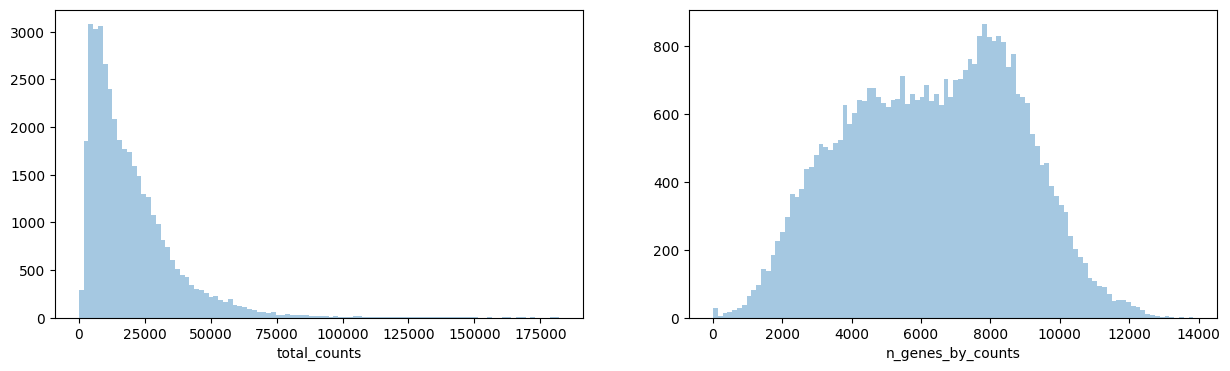

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

sc.pp.calculate_qc_metrics(adata, qc_vars=["MT"], inplace=True)
fig, axs = plt.subplots(1,2, figsize=(15, 4))
sns.distplot(adata.obs["total_counts"], kde=False, ax=axs[0], bins = 100)
sns.distplot(adata.obs["n_genes_by_counts"], kde=False, bins=100, ax=axs[1])

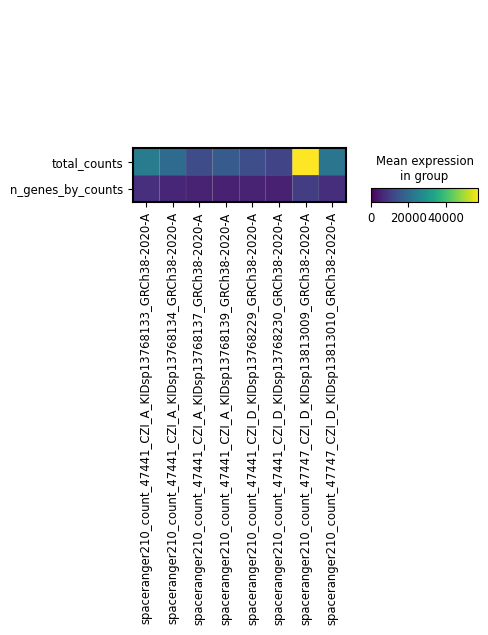

In [18]:
sc.pl.matrixplot(adata, var_names = ['total_counts', 'n_genes_by_counts'], groupby = 'sample', swap_axes = True, 
                vmin = 0)

In [19]:
adata.obs = adata.obs.dropna(axis=1, how='all')

In [20]:
adata.layers["counts"] = adata.X.copy()

sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
adata.raw = adata
adata.uns['raw_adata'] = adata.copy()

In [21]:
#some qc on spots
sc.pp.filter_cells(adata, min_genes=500)
# mitochondria-encoded (MT) genes should be removed for spatial mapping
adata = adata[:, ~adata.var['MT'].values]

/home/jovyan/my-conda-envs/myenv/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs['n_genes'] = number


In [22]:
slide_names = np.unique(adata.obs['sample'])

/home/jovyan/my-conda-envs/myenv/lib/python3.9/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value
/home/jovyan/my-conda-envs/myenv/lib/python3.9/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value
/home/jovyan/my-conda-envs/myenv/lib/python3.9/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value
/home/jovyan/my-conda-envs/myenv/lib/python3.9/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value
/home/jovyan/my-conda-envs/myenv/lib/python3.9/site-packages/anndata/compat/_overloaded_

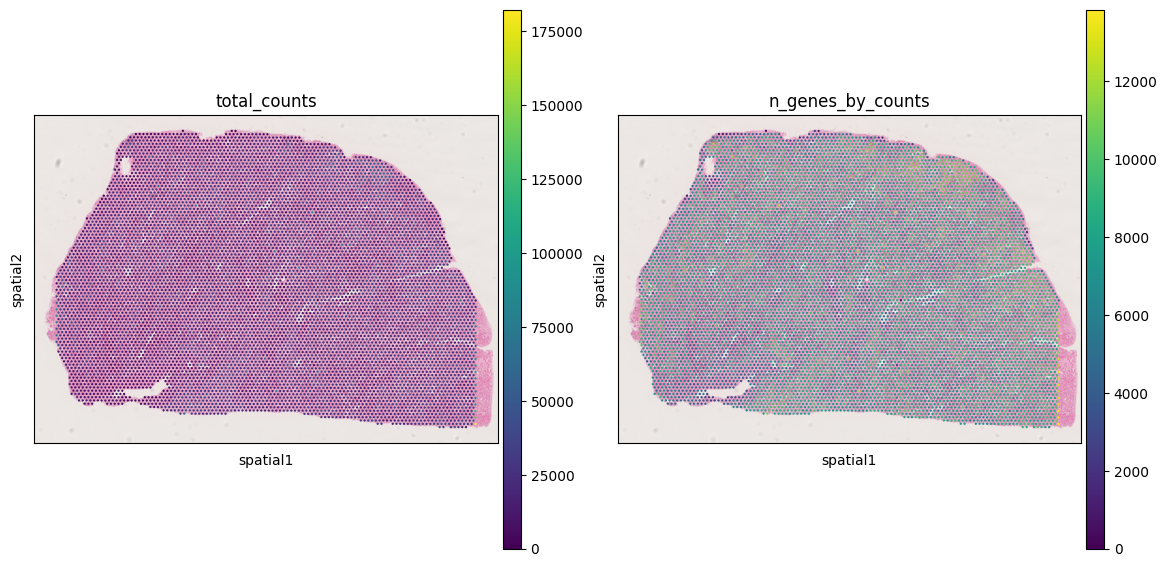

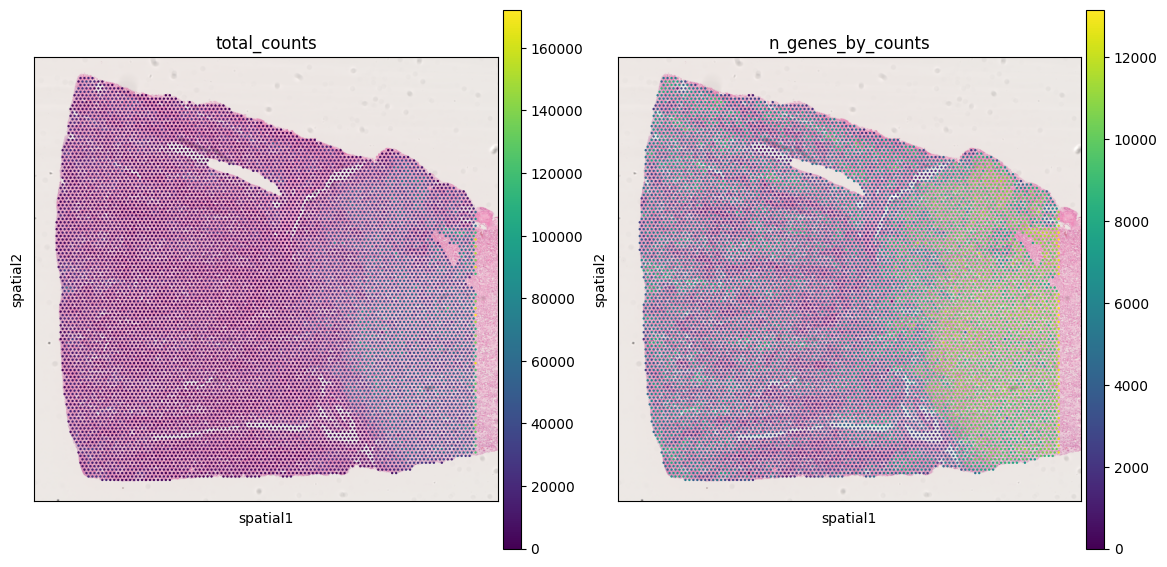

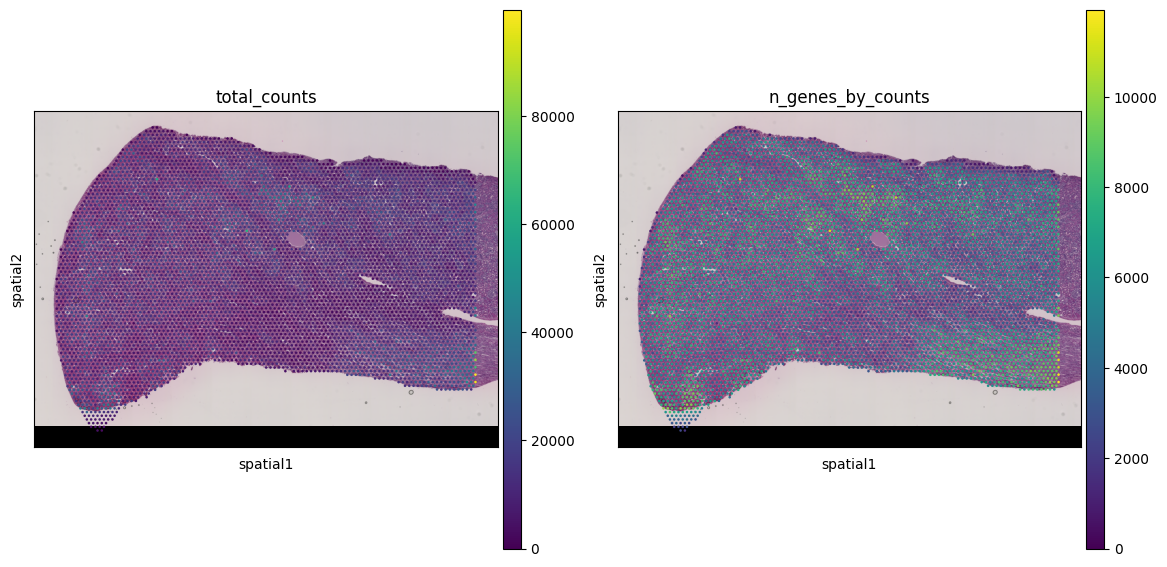

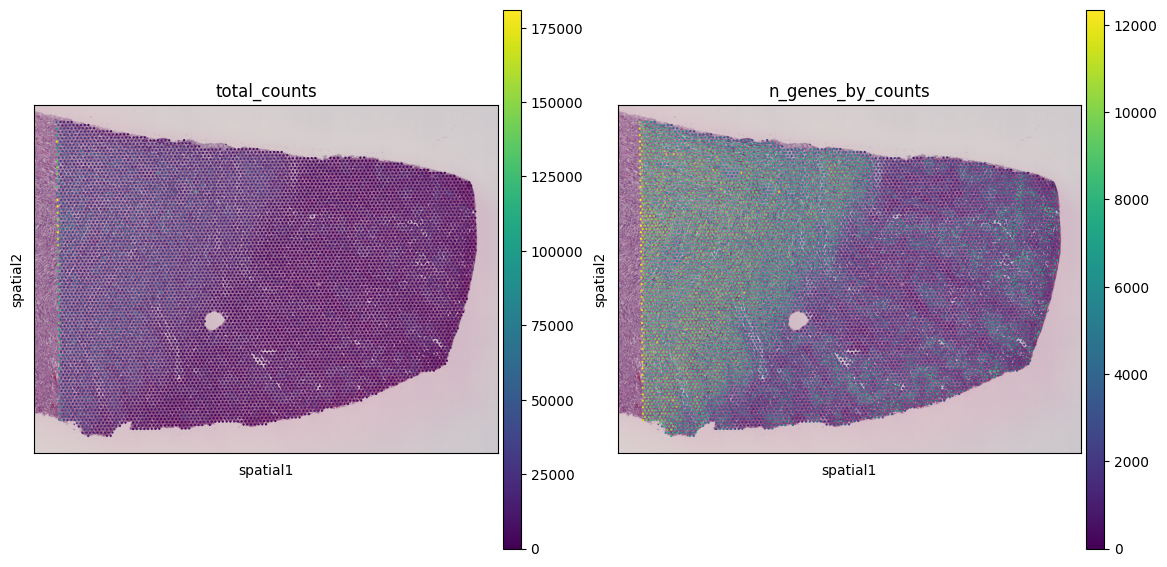

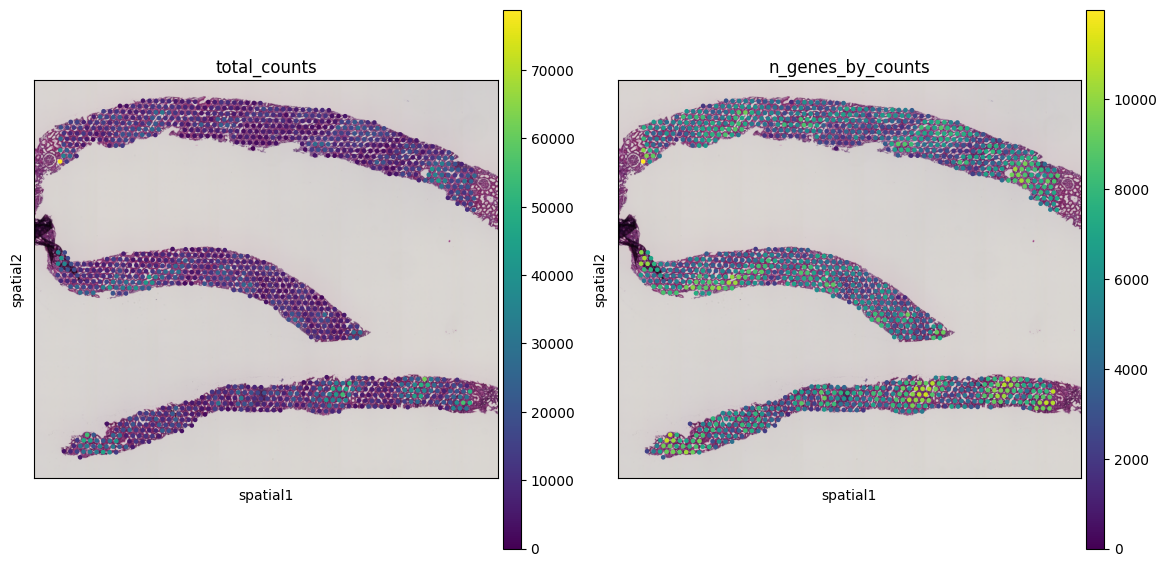

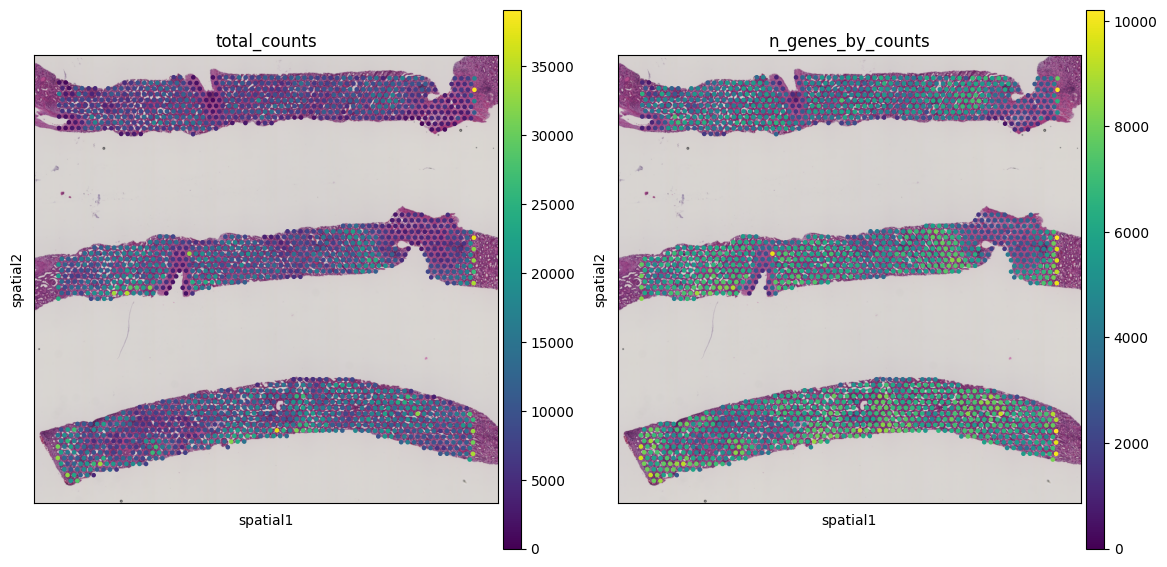

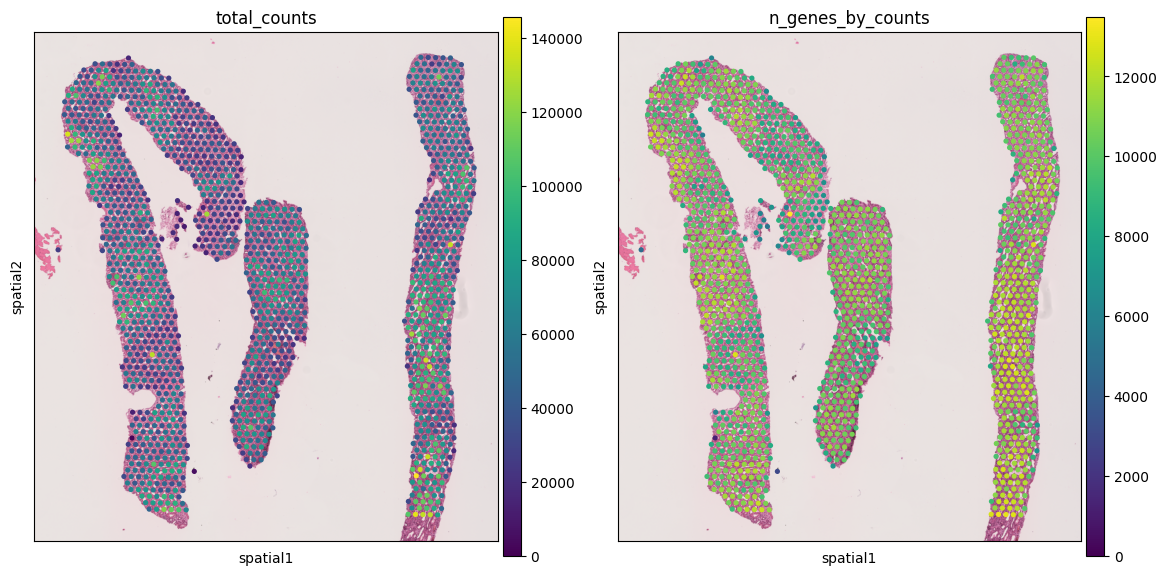

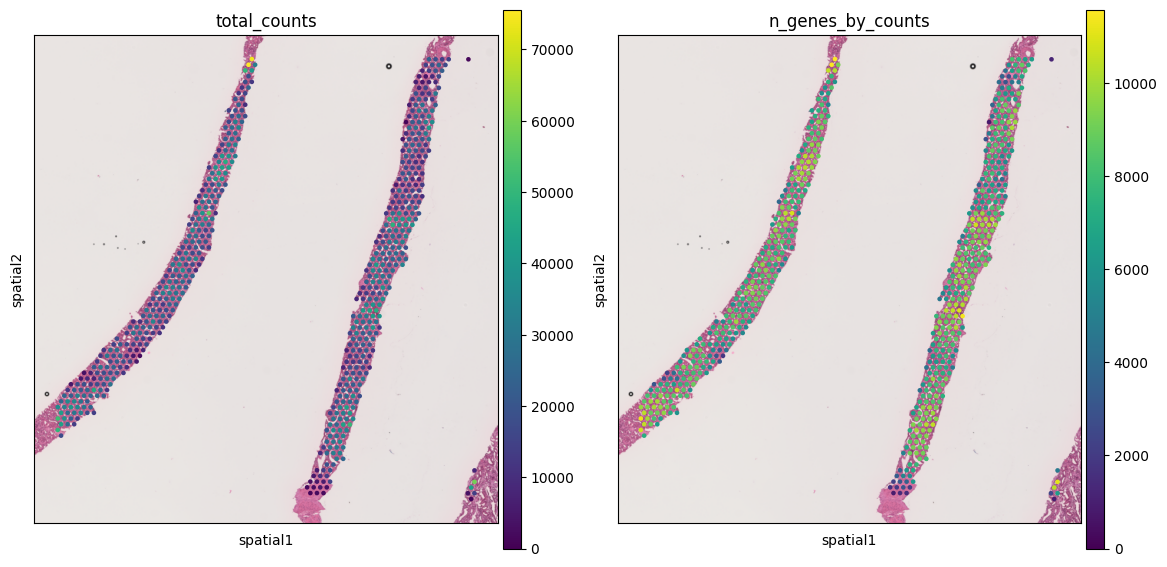

In [23]:
import matplotlib as mpl
from matplotlib import rcParams
for sl in slide_names:
    with mpl.rc_context({'figure.figsize': [6,7], 
                         'axes.facecolor': 'black'}):
        slide = select_slide(adata, sl)
        sc.pl.spatial(slide, img_key = "hires", cmap='viridis',
                  library_id=list(slide.uns['spatial'].keys())[0],
                  color=['total_counts', 'n_genes_by_counts'], size=1,
                  gene_symbols='SYMBOL', show=False, return_fig=True, add_outline = False, 
                     vmin = 0)


In [24]:
os.chdir('/lustre/scratch126/cellgen/team297/bs16/current_projects/kidney_glomTI_response')
adata.write_h5ad('data/raw/visium/kidney_visium.h5ad')